## 1 Preliminaries

## 1.1 Imports and Configurations

### Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import math

from pathlib import Path
from pandas.api.types import CategoricalDtype
from ydata_profiling import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

### Constants

In [44]:
# 1 Preliminaries

RANDOM_STATE = 42

MARKETING_PATH =  Path('../data/raw/customer_shopping_data.csv')
REPORTS_DIR = Path('../reports/')

FEATURES_TO_DEL = ['invoice_no', 'customer_id']

FEATURE_OUTLIER_THRESHOLDS = {
    'price': {'upper': 4000},
}

FEATURES_CAT = ['gender', 'category', 'payment_method', 'shopping_mall']
FEATURES_DATE = ['invoice_date']

FEATURE_ORD_LEVELS = {
    'quantity': ['1', '2', '3', '4', '5'],
}

# 2 Feature Utility Scores

MI_SCORES_FEATURE_TO_ESTIMATE = 'price'
MI_SCORES_THRESHOLD = 0

### Configs

In [3]:
warnings.filterwarnings('ignore')

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

REPORTS_DIR.mkdir(exist_ok=True)

## 1.2 Data Preprocessing

### Read

In [4]:
def read_data(path):
    return pd.read_csv(path)

In [5]:
df = read_data(MARKETING_PATH)
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


### Clean

In [6]:
def clean(df, features_to_del):
    df = df.drop(columns=features_to_del)
    return df

In [7]:
df = clean(df, FEATURES_TO_DEL) 
df.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


### Missing Values

In [8]:
df.isna().sum().sum()

0

### Outliers

In [9]:
def get_outlier_indexes(df, feature_outlier_thresholds):
    outlier_indexes = set()
    
    for feature, thresholds in feature_outlier_thresholds.items():
        if 'upper' in thresholds.keys():
            outlier_indexes = outlier_indexes.union(set(df[df[feature] > thresholds['upper']].index))
        elif 'lower' in thresholds.keys():
            outlier_indexes = outlier_indexes.union(set(df[df[feature] < thresholds['lower']].index))

    return list(outlier_indexes)

In [10]:
def drop_outliers(df, outlier_indexes):
    return df.drop(index=outlier_indexes)

In [13]:
outlier_indexes = get_outlier_indexes(df, FEATURE_OUTLIER_THRESHOLDS)
len(outlier_indexes)

2002

In [14]:
df_without_outliers = drop_outliers(df, outlier_indexes)
df_without_outliers.shape

(97455, 8)

### Encode

In [17]:
def encode(df, features_cat, features_date, feature_ord_levels, format='%d-%m-%Y'):
    
    def encode_cat(df, features_cat):
        for feature in features_cat:
            df[feature] = df[feature].astype('category')
        return df

    def encode_date(df, features_date):
        for feature in features_date:
            df[feature] = pd.to_datetime(df[feature], format=format)
        return df

    def encode_ord(df, feature_ord_levels):
        for feature, levels in feature_ord_levels.items():
            df[feature] = df[feature].astype(CategoricalDtype(levels, ordered=True))
        return df
    
    df = encode_cat(df, features_cat)
    df = encode_date(df, features_date)
    df = encode_ord(df, feature_ord_levels)
    return df

In [18]:
df = encode(df, FEATURES_CAT,  FEATURES_DATE, FEATURE_ORD_LEVELS, format='%d/%m/%Y')
df.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,Female,28,Clothing,NaN,1500.40,Credit Card,2022-08-05,Kanyon
1,Male,21,Shoes,NaN,1800.51,Debit Card,2021-12-12,Forum Istanbul
2,Male,20,Clothing,NaN,300.08,Cash,2021-11-09,Metrocity
3,Female,66,Shoes,NaN,3000.85,Credit Card,2021-05-16,Metropol AVM
4,Female,53,Books,NaN,60.60,Cash,2021-10-24,Kanyon


In [19]:
df.dtypes

gender                  category
age                        int64
category                category
quantity                category
price                    float64
payment_method          category
invoice_date      datetime64[ns]
shopping_mall           category
dtype: object

### Summary

In [24]:
def load_data(path, features_to_del, features_cat, features_date, feature_ord_levels):
    df = read_data(path)
    df = clean(df, features_to_del)
    #df = impute(df)

    outlier_indexes = get_outlier_indexes(df, FEATURE_OUTLIER_THRESHOLDS)
    df = drop_outliers(df, outlier_indexes)
    
    df = encode(df, features_cat, features_date, feature_ord_levels, format='%d/%m/%Y')
    return df

In [25]:
df = load_data(MARKETING_PATH, FEATURES_TO_DEL, FEATURES_CAT, FEATURES_DATE, FEATURE_ORD_LEVELS)
df.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,Female,28,Clothing,NaN,1500.40,Credit Card,2022-08-05,Kanyon
1,Male,21,Shoes,NaN,1800.51,Debit Card,2021-12-12,Forum Istanbul
2,Male,20,Clothing,NaN,300.08,Cash,2021-11-09,Metrocity
3,Female,66,Shoes,NaN,3000.85,Credit Card,2021-05-16,Metropol AVM
4,Female,53,Books,NaN,60.60,Cash,2021-10-24,Kanyon


In [27]:
df.isna().sum().sum()

97455

In [28]:
df.dtypes

gender                  category
age                        int64
category                category
quantity                category
price                    float64
payment_method          category
invoice_date      datetime64[ns]
shopping_mall           category
dtype: object

## 2 Feature Utility Scores

## 2.1 MI Scores

In [45]:
def make_mi_scores(X, y, random_state=0):
    X = X.copy()
    for feature in X.select_dtypes(['object', 'category', 'datetime64[ns]']):
        X[feature], _ = X[feature].factorize()
        
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=random_state)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [46]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title('Mutual Information Scores')

In [47]:
X_mi = df.copy()
y_mi = X_mi.pop(MI_SCORES_FEATURE_TO_ESTIMATE)

mi_scores = make_mi_scores(X_mi, y_mi, random_state=RANDOM_STATE)
mi_scores

category          1.823628
invoice_date      0.003821
age               0.002029
quantity          0.000898
gender            0.000000
payment_method    0.000000
shopping_mall     0.000000
Name: MI Scores, dtype: float64

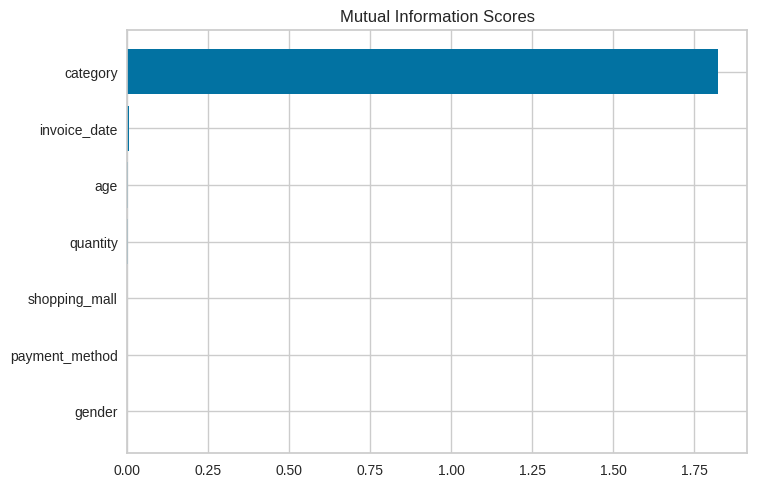

In [48]:
plot_mi_scores(mi_scores)